In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME') + '/aiffel/recommend_system/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0,1,2,3], dtype={0: np.int32, 1:np.int32, 2:np.int32},nrows=nrows)
    data.columns= ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


세션
- 사용자가 웹 서버에 접속해 있는 상태를 하나의 단위로 인식
- 동일한 사용자가 한번 방문하여 발생시킨 '히트'의 집합
- 히트를 하나의 세션으로 그룹화해서 30분 동안 아무런 활동이 없는 경우 세션이 종료(구글 애널리스틱 경우)

In [3]:
# 추천 시스템 구축할 떄 가장 먼저 확인해 볼 것은 유저수(세션 수)와 영화 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
# UserId와 Time 기준으로 새로운 데이터 프레임 생성
df = data.groupby(['UserId','Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
# SessionId 컬럼 추가
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns=['UserId', 'ItemId', 'Rating', 'Time', 'SessionID']
data

,UserId,ItemId,Rating,Time,SessionID
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161



여러 유저가 여러 번 접속하여 평가를 남긴 기록이므로 UserId와 Time을 모두 고려했고, <br>
고유한 (UserId, Time)의 쌍을 하나의 Session으로 정의했다.

In [51]:
# SessionId별 몇개의 영화 평가 ?
session_length = data.groupby('SessionID').size()
session_length
# data['SessionID'].nunique()

SessionID
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [52]:
# 세션 중앙값, 세션 평균값
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

평균적으로 한 세션당 2개를 평가

In [53]:
#세션 최소값, 최대값
session_length.min(), session_length.max()

(1, 30)

적게는 1개 최대 30개 까지 평가함

In [54]:
session_length.quantile(0.999)

10.0

전체 세션의 99.9%가 10개 이하의 평가를 남김 <br>
30개는 이상치로 볼 수 있음

In [55]:
long_session = session_length[session_length==30].index[0]
data[data['SessionID']==long_session]

,UserId,ItemId,Rating,Time,SessionID
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [56]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

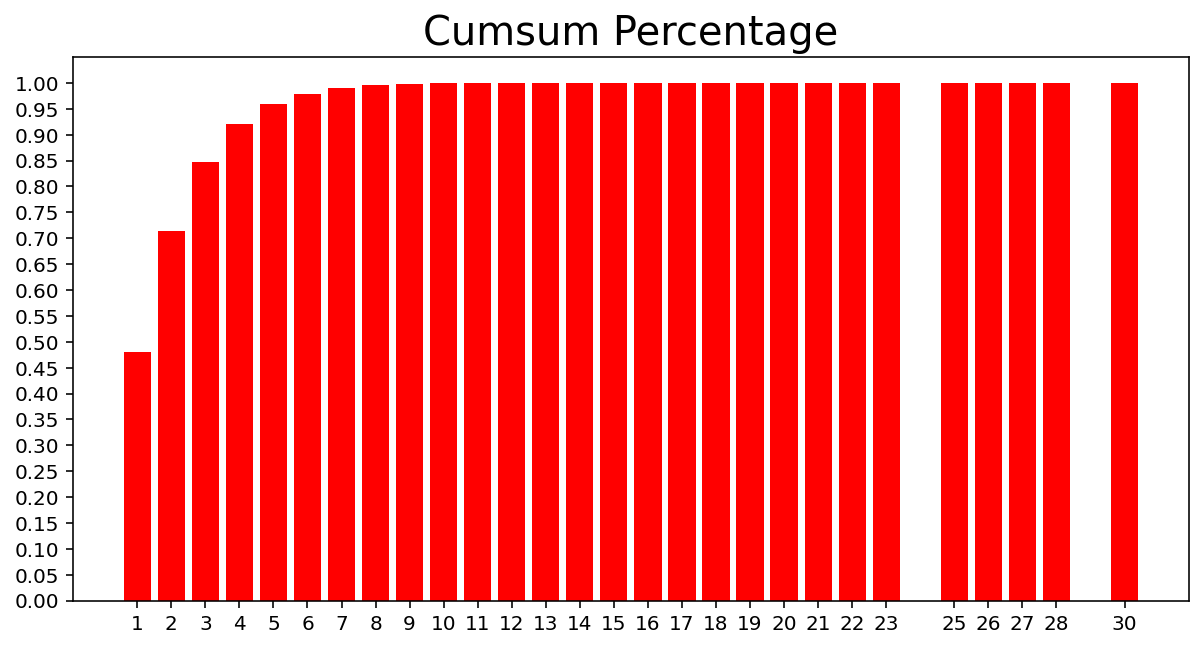

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='red')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()


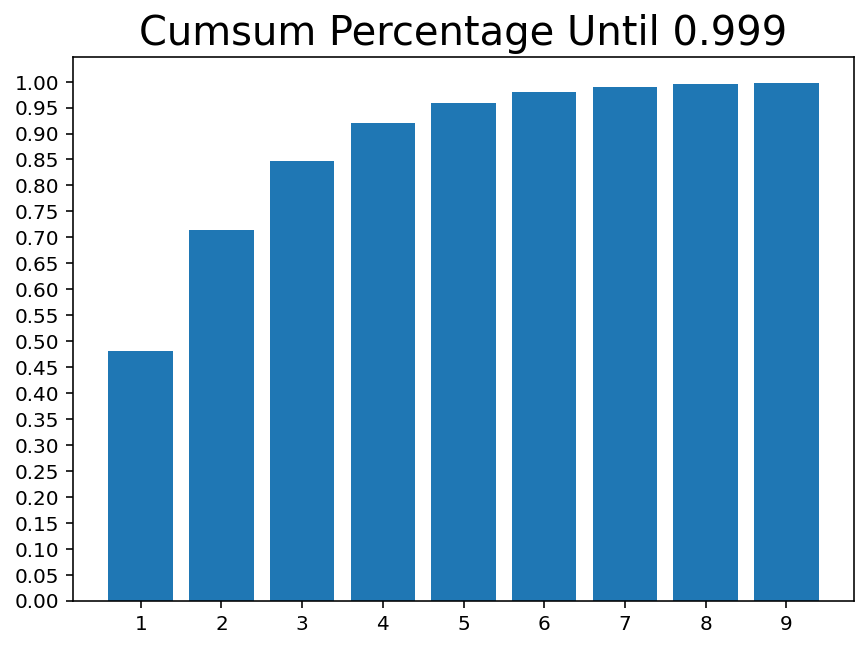

In [58]:
plt.figure(figsize=(7, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### time

In [59]:
# 데이터의 시간 관련 정보를 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [60]:
# 일반적인 시간으로 변경
data['Time'] =pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time,SessionID
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


영화는 보통 3점 이상은 추천할만하다고 생각하기에<br>
rating 3점 이상만

In [61]:
# data = data[data['Rating']>=3]
# data

### 데이터의 전처리

In [62]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


2년 10개월 데이터 확인

In [63]:
month_ago = latest - dt.timedelta(1038) # 데이터를 거의다 사용하겠다.
# print(month_ago)
# data[data['Time'] > month_ago]
data = data[data['Time'] > month_ago] # 방금 구한 날짜 이후의 데이터만 모은다
data

,UserId,ItemId,Rating,Time,SessionID
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### Train/Valid/Test split

In [64]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionID')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionID'].isin(session_in_train)]
    after_date = data[data['SessionID'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [65]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [66]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [67]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 986742
	 Sessions: 6020
	 Items: 3702
	 First Time : 2000-04-26 19:12:20
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 5209
	 Sessions: 245
	 Items: 1949
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 5073
	 Sessions: 254
	 Items: 1893
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [68]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [69]:
# 데이터 저장한 다음 data pipeline을 구축하는 단계로 
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_movie.pkl')
val.to_pickle(save_path / 'valid_movie.pkl')
test.to_pickle(save_path / 'test_movie.pkl')

## Data Pipeline

In [70]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionID'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionID'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionID').size().cumsum()
        return offsets

In [71]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionID,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [72]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 986740, 986741, 986742], dtype=int32)

In [73]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 462858, 462859, 462860])

### sessionDataLoader

In [74]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [75]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionID,item_idx
0,1,3186,4,2000-12-31 22:00:19,0,0
1,1,1270,5,2000-12-31 22:00:55,1,1
2,1,1721,4,2000-12-31 22:00:55,1,2
3,1,1022,5,2000-12-31 22:00:55,1,3
4,1,2340,3,2000-12-31 22:01:43,2,4
5,1,1836,5,2000-12-31 22:02:52,3,5
6,1,3408,4,2000-12-31 22:04:35,4,6
7,1,2804,5,2000-12-31 22:11:59,5,7
8,1,1207,4,2000-12-31 22:11:59,5,8
9,1,1193,5,2000-12-31 22:12:40,6,9


In [76]:
iter_ex = iter(tr_data_loader)

In [77]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## Modeling

#### Evaluation Metric

In [78]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [86]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [87]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionID'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [88]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(256, 1, 3702)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               563100    
                              (256, 50)]                         
                                                                 
 dropout_3 (Dropout)         (256, 50)                 0         
                                                                 
 dense_3 (Dense)             (256, 3702)               188802    
                                                                 
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [89]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionID'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionID'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [90]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  83%|████████▎ | 5/6 [00:05<00:01,  1.01s/it]


	 - Recall@20 epoch 1: 0.071875
	 - MRR@20    epoch 1: 0.023527



Evaluation:  83%|████████▎ | 5/6 [00:02<00:00,  1.90it/s]


	 - Recall@20 epoch 2: 0.145313
	 - MRR@20    epoch 2: 0.047314



Evaluation:  83%|████████▎ | 5/6 [00:02<00:00,  1.93it/s]

	 - Recall@20 epoch 3: 0.165625
	 - MRR@20    epoch 3: 0.052831



In [91]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

	 - Recall@20: 0.217969
	 - MRR@20: 0.080509



파라미터 변경

In [92]:
# 배치사이즈를 줄이고 에포크를 늘리고, drop_rate를 높였다.
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)

In [93]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(128, 1, 3702)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               563100    
                              (128, 50)]                         
                                                                 
 dropout_4 (Dropout)         (128, 50)                 0         
                                                                 
 dense_4 (Dense)             (128, 3702)               188802    
                                                                 
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


In [94]:
train_model(model, args)


Evaluation:  92%|█████████▏| 11/12 [00:03<00:00,  3.28it/s]


	 - Recall@20 epoch 1: 0.076705
	 - MRR@20    epoch 1: 0.024218



Evaluation:  92%|█████████▏| 11/12 [00:03<00:00,  3.53it/s]


	 - Recall@20 epoch 2: 0.156960
	 - MRR@20    epoch 2: 0.051426



Evaluation:  92%|█████████▏| 11/12 [00:02<00:00,  3.67it/s]


	 - Recall@20 epoch 3: 0.180398
	 - MRR@20    epoch 3: 0.059236



Evaluation:  92%|█████████▏| 11/12 [00:03<00:00,  3.64it/s]


	 - Recall@20 epoch 4: 0.193182
	 - MRR@20    epoch 4: 0.064680



Evaluation:  92%|█████████▏| 11/12 [00:03<00:00,  3.61it/s]


	 - Recall@20 epoch 5: 0.194602
	 - MRR@20    epoch 5: 0.065688



Evaluation:  92%|█████████▏| 11/12 [00:02<00:00,  3.71it/s]


	 - Recall@20 epoch 6: 0.196733
	 - MRR@20    epoch 6: 0.066618



Evaluation:  92%|█████████▏| 11/12 [00:03<00:00,  3.65it/s]


	 - Recall@20 epoch 7: 0.200284
	 - MRR@20    epoch 7: 0.068577



Evaluation:  92%|█████████▏| 11/12 [00:02<00:00,  3.68it/s]


	 - Recall@20 epoch 8: 0.203125
	 - MRR@20    epoch 8: 0.068622



Evaluation:  92%|█████████▏| 11/12 [00:02<00:00,  3.72it/s]


	 - Recall@20 epoch 9: 0.200994
	 - MRR@20    epoch 9: 0.069456



Evaluation:  92%|█████████▏| 11/12 [00:02<00:00,  3.68it/s]

	 - Recall@20 epoch 10: 0.199574
	 - MRR@20    epoch 10: 0.070036



In [95]:
test_model(model, args, test)

Evaluation:  91%|█████████ | 10/11 [00:02<00:00,  4.08it/s]

	 - Recall@20: 0.263281
	 - MRR@20: 0.099123



In [96]:
# 배치사이즈를 줄이고 에포크를 늘리고, drop_rate를 이전보다 줄임, k값 줄임
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.25, lr=0.001, epochs=25, k=10)

In [97]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(64, 1, 3702)]           0         
                                                                 
 GRU (GRU)                   [(64, 50),                563100    
                              (64, 50)]                          
                                                                 
 dropout_5 (Dropout)         (64, 50)                  0         
                                                                 
 dense_5 (Dense)             (64, 3702)                188802    
                                                                 
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


In [98]:
train_model(model, args)


Evaluation:  96%|█████████▌| 23/24 [00:02<00:00,  9.84it/s]


	 - Recall@10 epoch 1: 0.094429
	 - MRR@10    epoch 1: 0.043838



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.75it/s]


	 - Recall@10 epoch 2: 0.124321
	 - MRR@10    epoch 2: 0.054784



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.75it/s]


	 - Recall@10 epoch 3: 0.131793
	 - MRR@10    epoch 3: 0.059726



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.77it/s]


	 - Recall@10 epoch 4: 0.130435
	 - MRR@10    epoch 4: 0.060629



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.76it/s]


	 - Recall@10 epoch 5: 0.133152
	 - MRR@10    epoch 5: 0.061035



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.69it/s]


	 - Recall@10 epoch 6: 0.131793
	 - MRR@10    epoch 6: 0.061554



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.77it/s]


	 - Recall@10 epoch 7: 0.132473
	 - MRR@10    epoch 7: 0.062134



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.16it/s]


	 - Recall@10 epoch 8: 0.133152
	 - MRR@10    epoch 8: 0.062178



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.65it/s]


	 - Recall@10 epoch 9: 0.132473
	 - MRR@10    epoch 9: 0.062141



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.78it/s]


	 - Recall@10 epoch 10: 0.134511
	 - MRR@10    epoch 10: 0.063151



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.80it/s]


	 - Recall@10 epoch 11: 0.133152
	 - MRR@10    epoch 11: 0.062039



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.75it/s]


	 - Recall@10 epoch 12: 0.135190
	 - MRR@10    epoch 12: 0.062774



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.65it/s]


	 - Recall@10 epoch 13: 0.134511
	 - MRR@10    epoch 13: 0.062468



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.75it/s]


	 - Recall@10 epoch 14: 0.131114
	 - MRR@10    epoch 14: 0.061909



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.62it/s]


	 - Recall@10 epoch 15: 0.132473
	 - MRR@10    epoch 15: 0.062561



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.78it/s]


	 - Recall@10 epoch 16: 0.132473
	 - MRR@10    epoch 16: 0.062907



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.79it/s]


	 - Recall@10 epoch 17: 0.129755
	 - MRR@10    epoch 17: 0.062605



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.52it/s]


	 - Recall@10 epoch 18: 0.131114
	 - MRR@10    epoch 18: 0.062701



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.57it/s]


	 - Recall@10 epoch 19: 0.131114
	 - MRR@10    epoch 19: 0.063217



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00,  9.01it/s]


	 - Recall@10 epoch 20: 0.129755
	 - MRR@10    epoch 20: 0.062523



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.98it/s]


	 - Recall@10 epoch 21: 0.129755
	 - MRR@10    epoch 21: 0.062123



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.53it/s]


	 - Recall@10 epoch 22: 0.130435
	 - MRR@10    epoch 22: 0.062992



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.67it/s]


	 - Recall@10 epoch 23: 0.130435
	 - MRR@10    epoch 23: 0.063556



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.69it/s]


	 - Recall@10 epoch 24: 0.129076
	 - MRR@10    epoch 24: 0.063156



Evaluation:  96%|█████████▌| 23/24 [00:02<00:00, 10.66it/s]

	 - Recall@10 epoch 25: 0.129076
	 - MRR@10    epoch 25: 0.062979



In [99]:
test_model(model, args, test)

Evaluation:  96%|█████████▌| 22/23 [00:02<00:00,  7.61it/s]

	 - Recall@10: 0.257812
	 - MRR@10: 0.099570



## ㄷ

# 회고
 -